# System Imbalance

This section analyzes the quarterly hours of system imbalance in the Italian electricity market (*TERNA_SUNSET_SEGNO_QH*), focusing on the characteristics of imbalances in the northern and southern macrozones.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

# Add the source directory to the system path
sys.path.append(os.path.abspath('../../src'))
from open_data import fetch_db_table_sqlserver16
import matplotlib.pyplot as plt

# SQL query to fetch data
sql_query = "SELECT * FROM TERNA_SUNSET_SEGNO_QH" 
qh = fetch_db_table_sqlserver16(sql=sql_query, verbose=False)
qh = qh.sort_values(by='ORAINI')

qh.tail()

c:\imbalance_forecast\src\open_data.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con, params=parameters)


,MACROZONA,ORAINI,FLOWDATE,FLOWHOUR,SBIL_MWH,SEGNO,SCAMBI_MWH,ESTERO_MWH,LOADTIME
406885,SUD,202410310915,20241031,10,-70.131,-,200.181,137.105,2024-10-31 10:13:07.217
406887,SUD,202410310930,20241031,10,60.563,+,160.034,138.418,2024-10-31 10:13:07.217
406886,NORD,202410310930,20241031,10,344.673,+,-160.034,1266.571,2024-10-31 10:13:07.217
406990,NORD,202410310945,20241031,10,446.154,+,-238.047,1473.086,2024-10-31 10:13:07.217
406991,SUD,202410310945,20241031,10,-25.207,-,238.047,138.409,2024-10-31 10:13:07.217


In [2]:
# Filter the DataFrame for the relevant columns and rows
qh = qh[['MACROZONA', 'ORAINI', 'SBIL_MWH']]
# Convert ORAINI to datetime using the correct method
qh['ORAINI'] = pd.to_datetime(qh['ORAINI'], format='%Y%m%d%H%M')
qh.set_index('ORAINI', inplace=True)
# Nord
qh_nord = qh[qh['MACROZONA'] == 'NORD']

# Sud
qh_sud = qh[qh['MACROZONA'] == 'SUD']

# Print the first few rows of the DataFrame
qh_nord

,MACROZONA,SBIL_MWH
ORAINI,,
2019-01-01 00:00:00,NORD,-47.312
2019-01-01 00:15:00,NORD,-30.343
2019-01-01 00:30:00,NORD,-20.311
2019-01-01 00:45:00,NORD,-13.934
2019-01-01 01:00:00,NORD,-65.080
...,...,...
2024-10-31 08:45:00,NORD,185.340
2024-10-31 09:00:00,NORD,117.293
2024-10-31 09:15:00,NORD,183.914


### Nord

In [3]:
print("Macro-scale descriptive stats (Nord macrozone):")
print(qh_nord["SBIL_MWH"].describe(),"\n")

Macro-scale descriptive stats (Nord macrozone):
count    203519.000000
mean         19.239698
std         157.350579
min       -1026.876000
25%         -66.017500
50%          15.061000
75%          98.578500
max        3056.247000
Name: SBIL_MWH, dtype: float64 



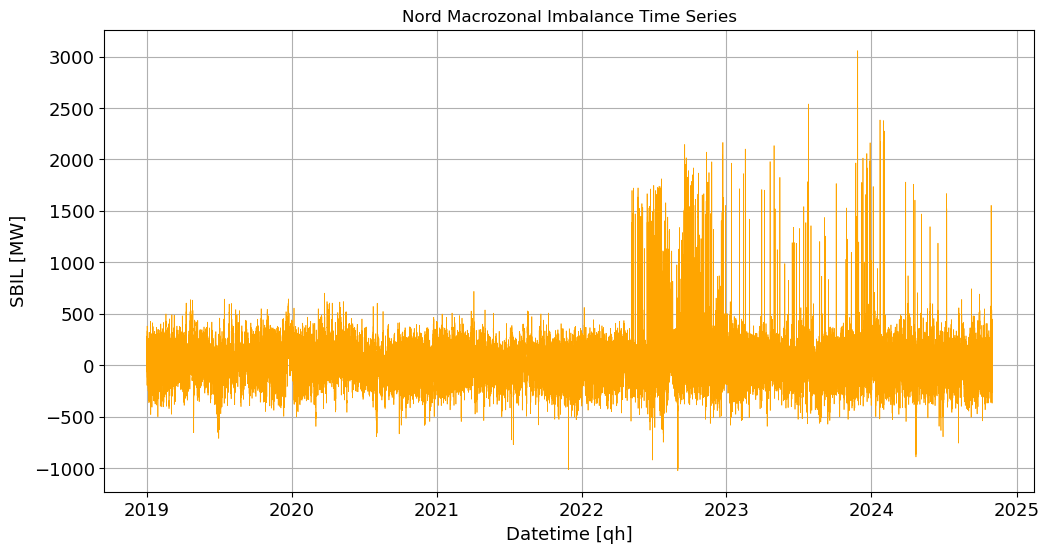

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(qh_nord["SBIL_MWH"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [qh]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Nord Macrozonal Imbalance Time Series")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

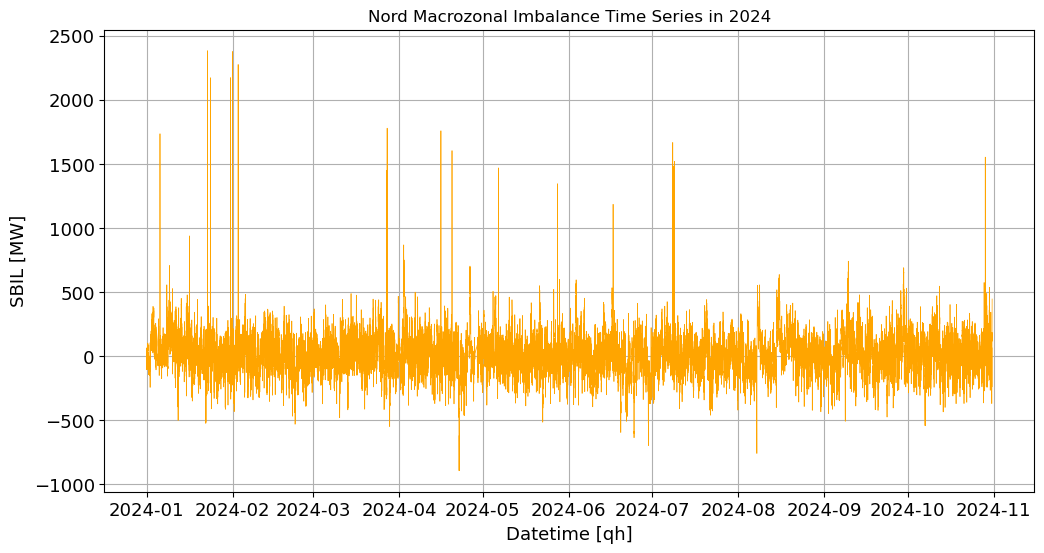

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(qh_nord["SBIL_MWH"].loc['2024'], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [qh]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Nord Macrozonal Imbalance Time Series in 2024")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

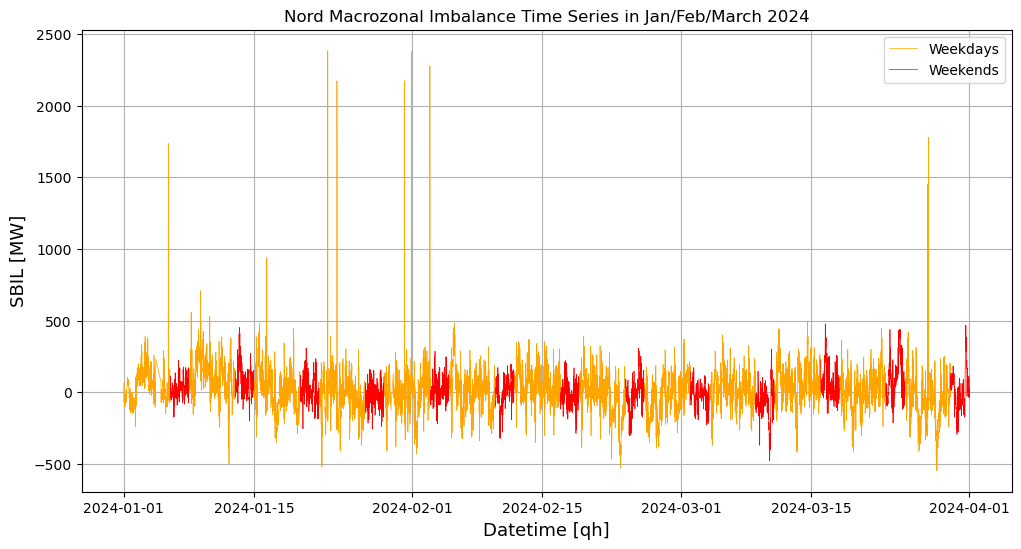

In [16]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Filter data for the specific month
data = qh_nord["SBIL_MWH"].loc['2024-01':'2024-03'] 

# Create two versions of the data for plotting with NaNs to break the lines for weekdays/weekends
weekends = np.where(data.index.weekday.isin([5, 6]), data, np.nan)  # Set weekdays to NaN
weekdays = np.where(~data.index.weekday.isin([5, 6]), data, np.nan)  # Set weekends to NaN

# Plot weekdays (continuous line, but only valid data points)
ax.plot(data.index, weekdays, linewidth=0.5, color='orange', label='Weekdays')

# Plot weekends (continuous line, but only valid data points)
ax.plot(data.index, weekends, linewidth=0.5, color='red', label='Weekends')

# Set labels and title
ax.set_xlabel("Datetime [qh]", fontsize=13)
ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Nord Macrozonal Imbalance Time Series in Jan/Feb/March 2024")
plt.grid()
ax.legend()  # Add a legend to differentiate the lines

plt.show()

<h3>KDE</h3>

The Kernel Density Estimator (KDE) provides a rational and visually pleasant representation of the data distribution, even if the data distribution is too irregular and does not resemble any of the usual PDFs

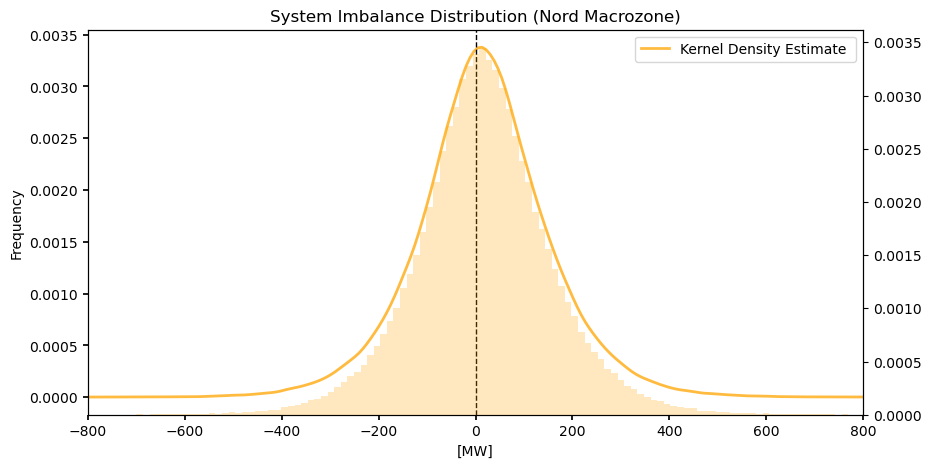

In [7]:
# Parameters
n_bins = 300  
DPI = 100  

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

# Plot Kernel Density Estimate (KDE)
qh_nord.plot(y="SBIL_MWH", ax=ax, kind="kde", color='orange', alpha=0.75,
        linewidth=2, label="Kernel Density Estimate ")

# Plot Histogram
qh_nord.plot(y="SBIL_MWH", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='orange', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)

# Set title and labels
ax.set_title("System Imbalance Distribution (Nord Macrozone)")
ax.set_xlabel("[MW]")

# Set x-limits for better visibility
ax.set_xlim(-800, 800)

# Customize ticks
ax.tick_params(width=1.25)

# Add a vertical line at x=0
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)

# Display legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

<h3> QQ-plot </h3>

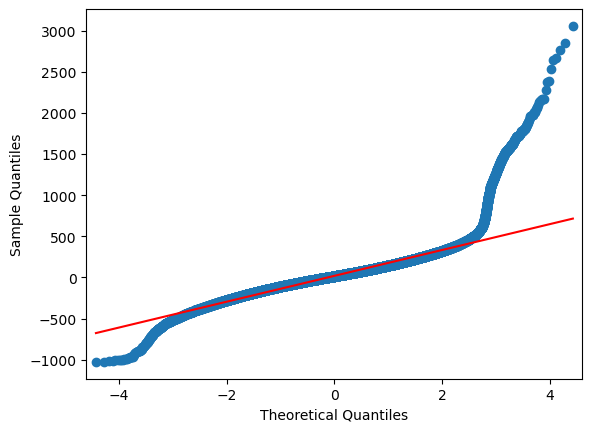

In [8]:
import numpy as np 
import statsmodels.api as sm 
import pylab as py 

sm.qqplot(qh_nord["SBIL_MWH"], line='s')

py.show()

In [9]:
from scipy.stats import kstest, norm
my_data = norm.rvs(size=1000)
ks_statistic, p_value = kstest(qh_nord["SBIL_MWH"], cdf="norm")
print(ks_statistic, p_value)

0.5402569796012158 0.0


In [10]:
from statsmodels.tsa.stattools import adfuller

#perform augmented Dickey-Fuller test
adf = adfuller(qh_nord["SBIL_MWH"])

print(adf)

(-30.394125531077602, 0.0, 81, 203432, {'1%': -3.4303821452992445, '5%': -2.8615542077982514, '10%': -2.566777562299973}, 2459644.127146749)


<h3>Hourly Distribution </h3>

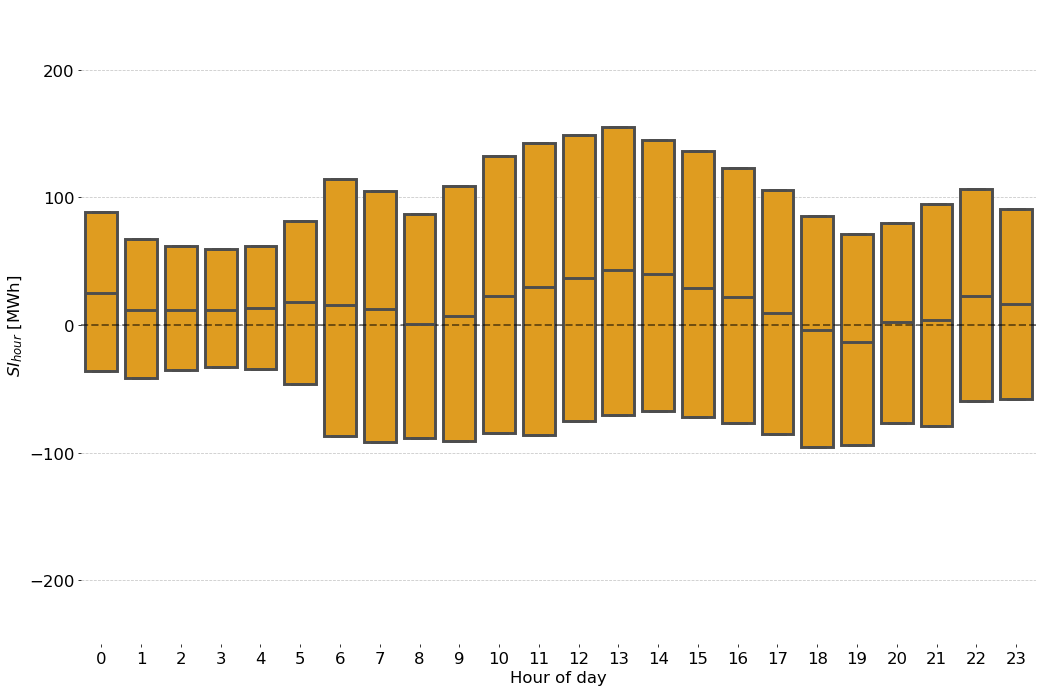

In [11]:
import seaborn as sns

DPI = 70

# Ensure you are working on a copy of the DataFrame
qh_nord_copy = qh_nord.copy()

# Extract hour from the ORAINI index and create a new column 'hour' using .loc
qh_nord_copy.loc[:, 'hour'] = qh_nord_copy.index.hour

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=qh_nord_copy, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='orange', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)

# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-250, 250])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


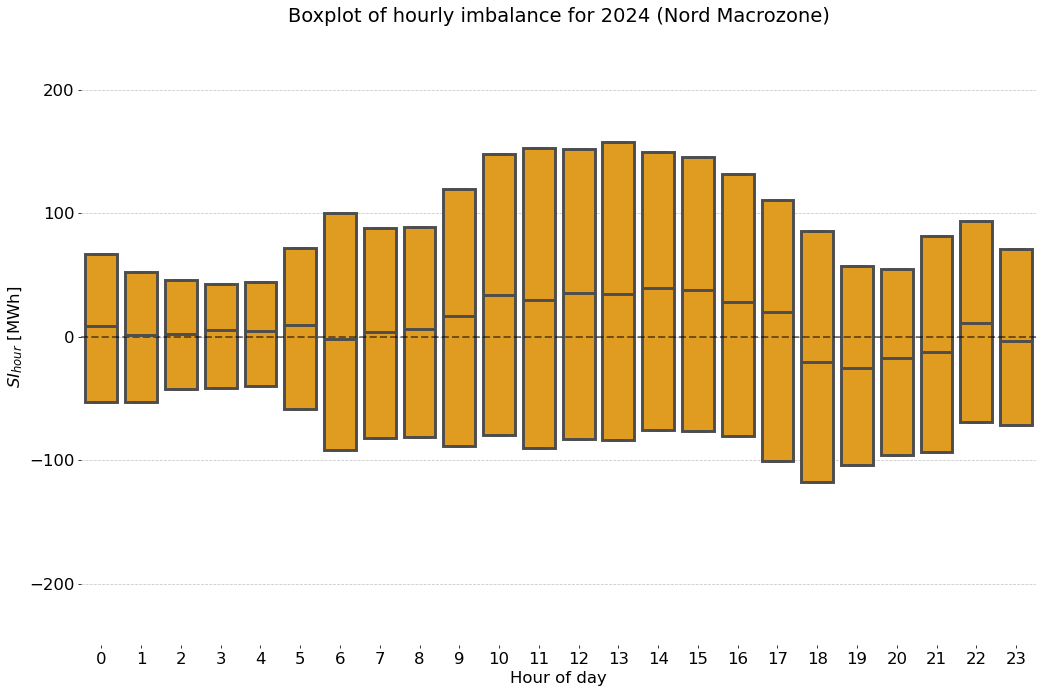

In [12]:
import seaborn as sns

DPI = 70

# Ensure you are working on a copy of the DataFrame
qh_nord_2024 = qh_nord.loc["2024"].copy()

# Extract hour from the ORAINI index and create a new column 'hour' using .loc
qh_nord_2024.loc[:, 'hour'] = qh_nord_2024.index.hour

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=qh_nord_2024, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='orange', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)
ax.set_title("Boxplot of hourly imbalance for 2024 (Nord Macrozone)", fontsize=20)
# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-250, 250])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


This plot seems to reflect higher negative imbalance at times of high load: in the afternoon (16:00-21:00), and somewhat during the morning too (6:00-9:00).

<h3>Volume over time</h3>

In [13]:
def calculate_imbalance_volume(group, how="sum"):
    if how == "sum":
        return group.abs().sum()*0.25*1e-3  # To obtain GWh (multiply by 1/4 h)
    elif how=="mean":
        return group.abs().mean() # To obtain average MW

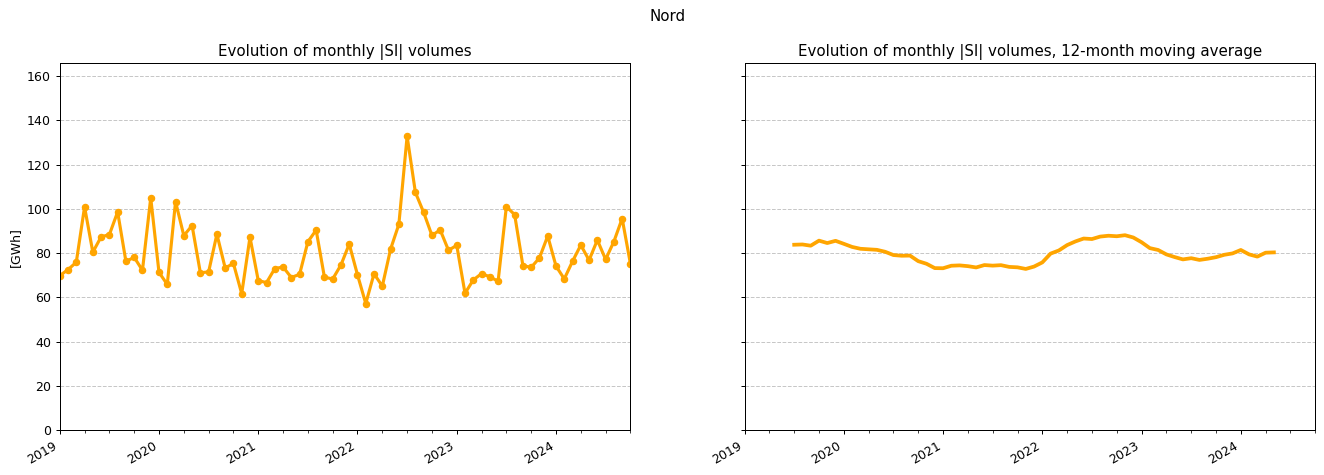

In [14]:
qh_nord_copy['year'] = qh_nord.index.year
qh_nord_copy['month'] = qh_nord.index.month

# Group by year and month, then apply the custom imbalance volume calculation
agg_month = (
    qh_nord_copy
    .groupby(by=["year", "month"])["SBIL_MWH"]
    .apply(calculate_imbalance_volume, how="sum")
)

# Adjust the date index range for the aggregated data
agg_month.index = pd.date_range(
    start=pd.Timestamp(f"{agg_month.index[0][0]}-{agg_month.index[0][1]}") - pd.DateOffset(months=0),
    end=pd.Timestamp(f"{agg_month.index[-1][0]}-{agg_month.index[-1][1]}") + pd.DateOffset(months=0),
    freq="1MS"
)

rolling_window = 12

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=90, sharex=True, sharey=True)

# Plot original monthly imbalance volume on the first subplot
agg_month.plot(ax=ax[0],
               ylabel="[GWh]",
               c="orange",
               linewidth=2.5,  # Increased linewidth for better visibility
               title=f"Evolution of monthly |SI| volumes")
agg_month.plot(ax=ax[0],
               style=".",
               color="orange",
               markersize=10)

# Plot rolling mean with the specified rolling window on the second subplot
agg_month.rolling(rolling_window, center=True).mean().plot(ax=ax[1],
                                                           ylabel="[GWh]",
                                                           c="orange",
                                                           linewidth=3,  # Increased line thickness for rolling average
                                                           title=f"Evolution of monthly |SI| volumes, {rolling_window}-month moving average")

# Set the y-axis limits dynamically based on the maximum value
plt.ylim(0, 1.25 * agg_month.max())


# Enable horizontal grid lines
ax[0].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to first plot
ax[1].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to second plot

# Automatically adjust x-axis label formatting
fig.autofmt_xdate()
fig.suptitle('Nord')
# Display the plot
plt.show()


<h3> ACF </h3>

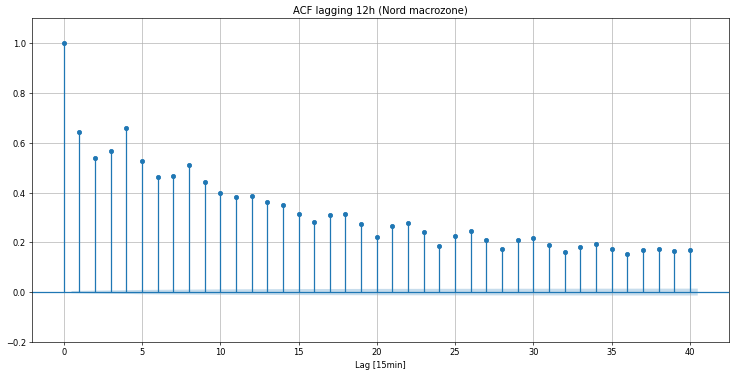

In [15]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_nord["SBIL_MWH"], alpha=.05, lags=4*10,
                         ax=ax, title="ACF lagging 12h (Nord macrozone)")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

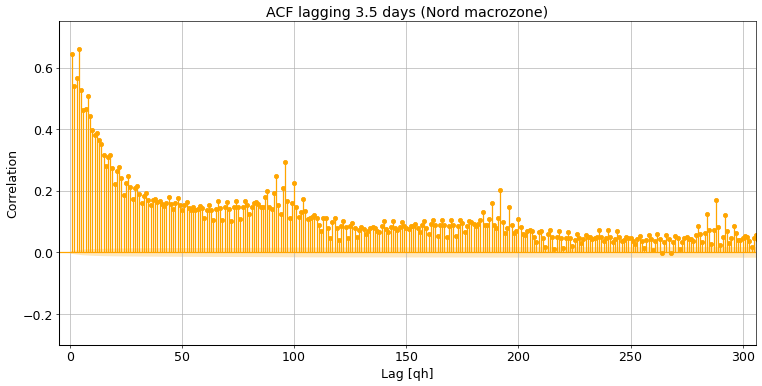

In [16]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_nord["SBIL_MWH"], alpha=.05, lags=4*24*3.5,
                         zero=False,
                         ax=ax,
                         color="orange", vlines_kwargs={"colors": "orange"})

ax.set_title("ACF lagging 3.5 days (Nord macrozone)", fontsize=17)
plt.ylim(-0.3, 0.75)
plt.xlim(-5, 4*24*3.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("orange")
plt.grid()
plt.show()


Autocorrelation function plot of system imbalance, with lags reaching up to three days in the past. Lag-0 is omitted.

Few comments:
- Any autocorrelation values outside this band are statistically significant at the 5% significance level. 
- The first ~10 lags again have the most significant partial autocorrelation, with those around lag-96 also showing noticeable levels.
- After lag ~100, the autocorrelations turn negative and stay consistently negative until around lag 250. Negative values indicate an inverse relationship, meaning high imbalance values are followed by low values (and vice versa) after these lags.
- The oscillatory nature of the ACF points to seasonality or periodic patterns in the data, potentially driven by recurring operational or demand patterns.

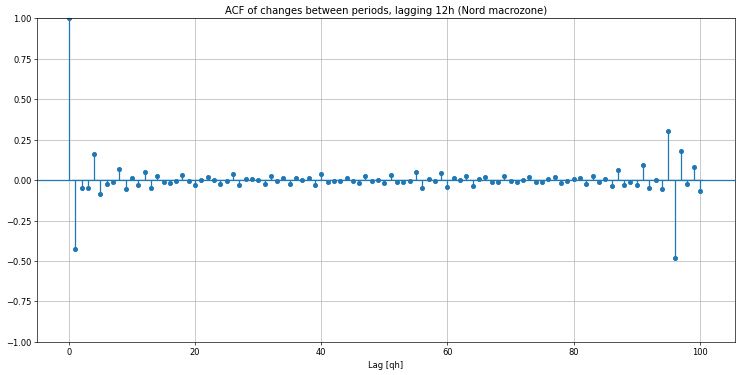

In [17]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_nord["SBIL_MWH"].diff().diff(4*24).dropna(), alpha=.05, lags=100,
                         ax=ax, title="ACF of changes between periods, lagging 12h (Nord macrozone)")
# plt.ylim(-0.3, 1.1)
plt.xlabel('Lag [qh]')
plt.grid()
plt.show()

<h3> PACF </h3>

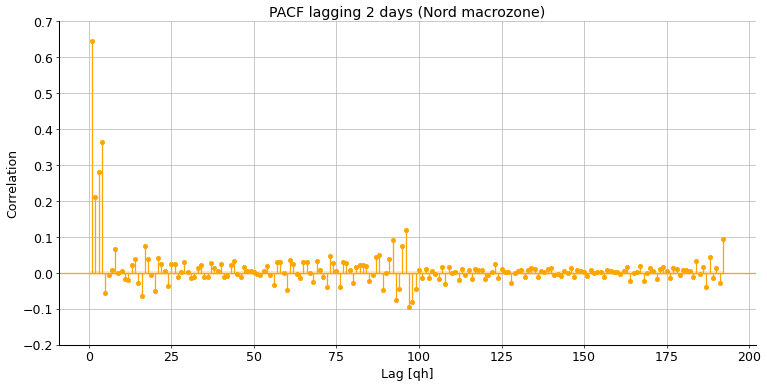

In [18]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_pacf(qh_nord["SBIL_MWH"], alpha=.05, lags=4*24*2, 
                         zero=False,
                         ax=ax,
                         color="orange", vlines_kwargs={"colors": "orange"})
plt.ylim(-0.2, 0.7)
# plt.xlim(-5, 4*24*2.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.set_title("PACF lagging 2 days (Nord macrozone)", fontsize=17)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("orange")
plt.grid()
plt.show()

Partial autocorrelation function plot of system imbalance, with lags reaching up to two days in the past. Lag-0 is omitted.


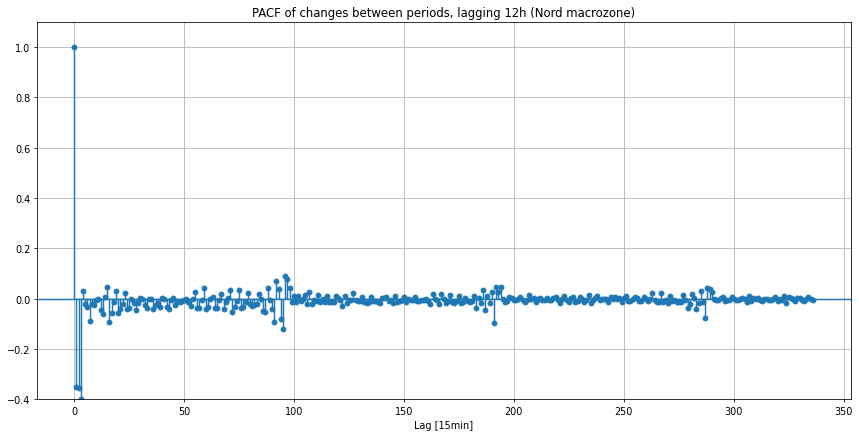

In [19]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_pacf(qh_nord["SBIL_MWH"].diff().dropna(), alpha=.05, lags=4*24*3.5, method="ywm", 
                          ax=ax, title="PACF of changes between periods, lagging 12h (Nord macrozone)")
plt.ylim([-0.4,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

<h3>STL decomposition </h3>

STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while Loess is a method for estimating nonlinear relationships. 

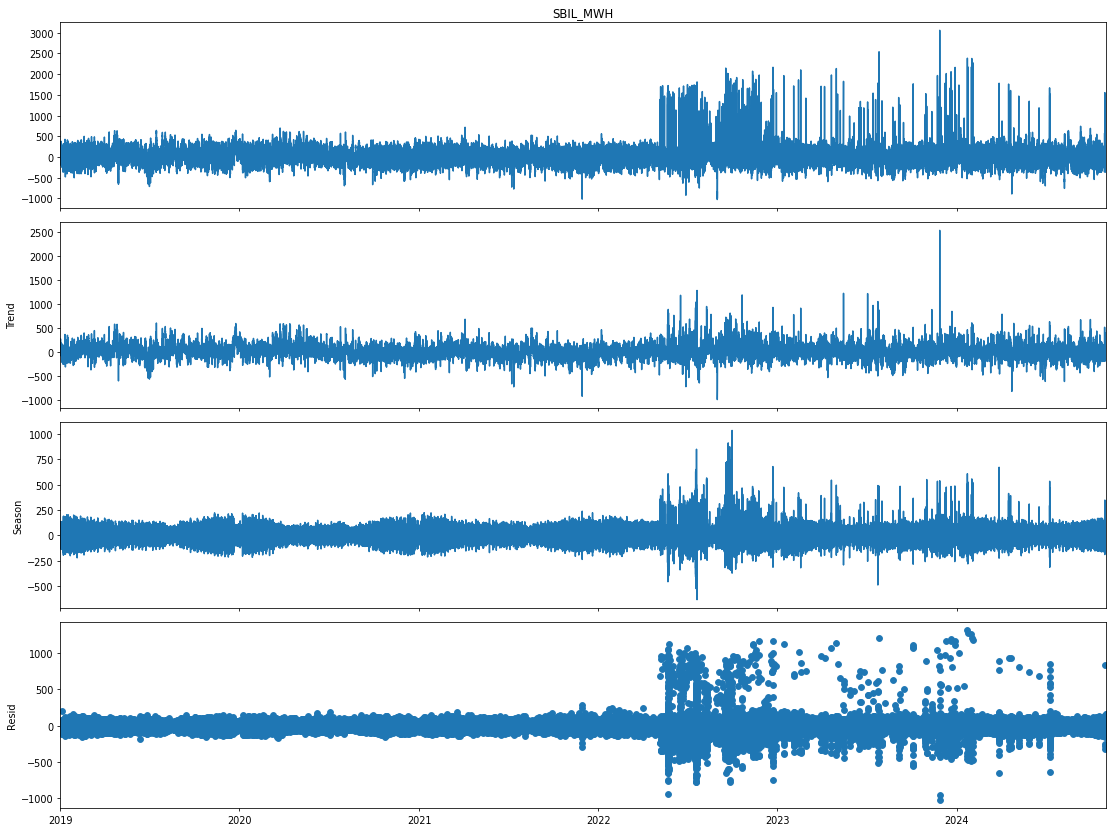

In [20]:
from statsmodels.tsa.seasonal import STL

# Attempt STL decomposition:
try_STL = True

if try_STL:
    decomp = STL(endog=qh_nord["SBIL_MWH"], period = 4).fit()   # , period=4, trend=int(4*24*7*4.35), seasonal=int(4*24*7*4.35), robust=True

    plt.rc('figure', figsize=(16, 12), dpi=DPI)
    decomp.plot()
    plt.show()
    plt.rcdefaults()

### Sud

In [21]:
print("Macro-scale descriptive stats (Sud Macrozone):")
print(qh_sud["SBIL_MWH"].describe(),"\n")

Macro-scale descriptive stats (Sud Macrozone):
count    203514.000000
mean         24.107986
std         150.940607
min       -1104.597000
25%         -65.981000
50%          22.957000
75%         113.681750
max        2190.469000
Name: SBIL_MWH, dtype: float64 



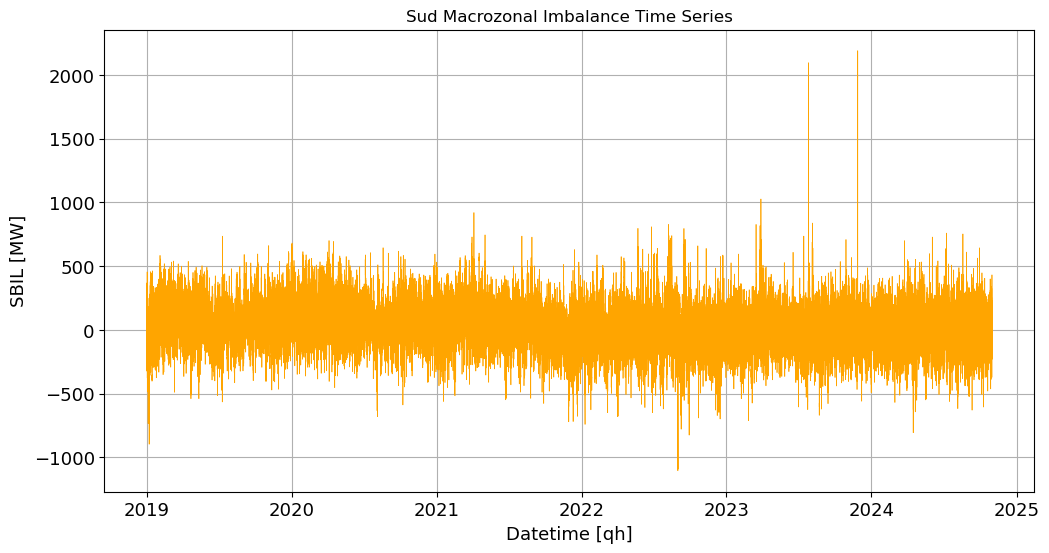

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(qh_sud["SBIL_MWH"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [qh]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Sud Macrozonal Imbalance Time Series")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

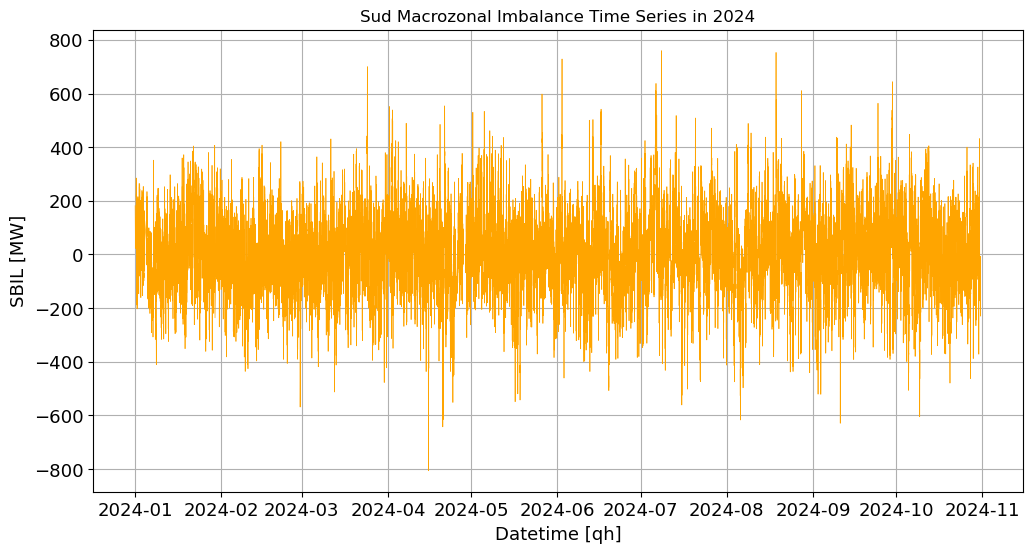

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(qh_sud["SBIL_MWH"].loc['2024'], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [qh]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Sud Macrozonal Imbalance Time Series in 2024")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

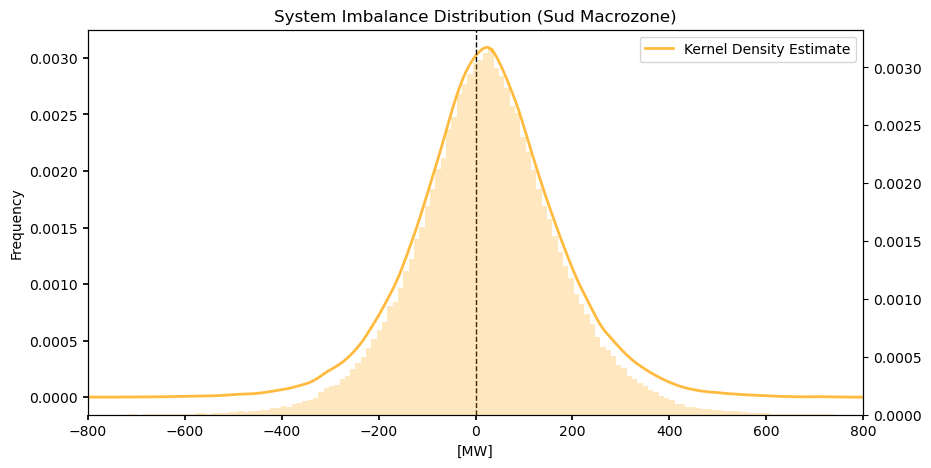

In [24]:
# Parameters
n_bins = 300  
DPI = 100  

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

# Plot Kernel Density Estimate (KDE)
qh_sud.plot(y="SBIL_MWH", ax=ax, kind="kde", color='orange', alpha=0.75,
        linewidth=2, label="Kernel Density Estimate")

# Plot Histogram
qh_sud.plot(y="SBIL_MWH", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='orange', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)

# Set title and labels
ax.set_title("System Imbalance Distribution (Sud Macrozone)")
ax.set_xlabel("[MW]")

# Set x-limits for better visibility
ax.set_xlim(-800, 800)

# Customize ticks
ax.tick_params(width=1.25)

# Add a vertical line at x=0
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)

# Display legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

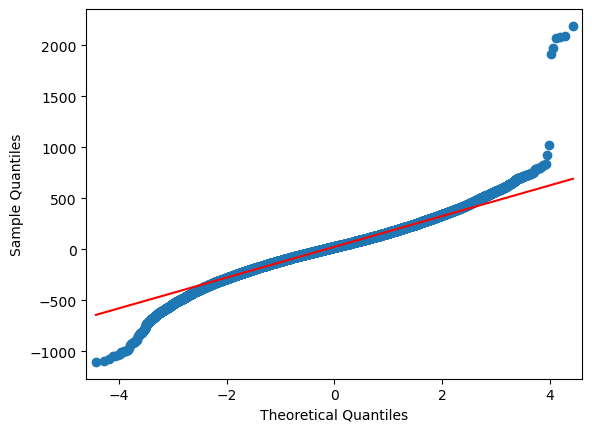

In [25]:
import numpy as np 
import statsmodels.api as sm 
import pylab as py 

sm.qqplot(qh_sud["SBIL_MWH"], line='s')

py.show()

In [26]:
my_data = norm.rvs(size=1000)
ks_statistic, p_value = kstest(qh_sud["SBIL_MWH"], cdf="norm")
print(ks_statistic, p_value)

0.5601861637617603 0.0


In [27]:
#perform augmented Dickey-Fuller test
adf = adfuller(qh_sud["SBIL_MWH"])

print(adf)

(-28.752472537072975, 0.0, 81, 203432, {'1%': -3.4303821452992445, '5%': -2.8615542077982514, '10%': -2.566777562299973}, 2252492.822161845)


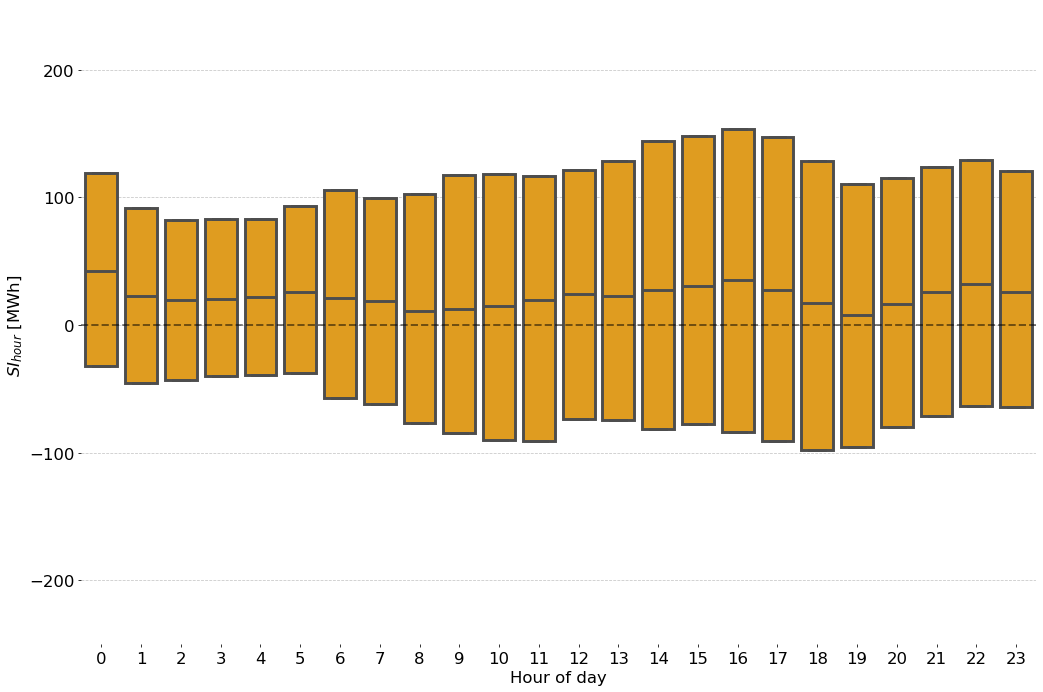

In [28]:
DPI = 70

# Ensure you are working on a copy of the DataFrame
qh_sud_copy = qh_sud.copy()

# Extract hour from the ORAINI index and create a new column 'hour' using .loc
qh_sud_copy.loc[:, 'hour'] = qh_sud_copy.index.hour

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=qh_sud_copy, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='orange', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)

# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-250, 250])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


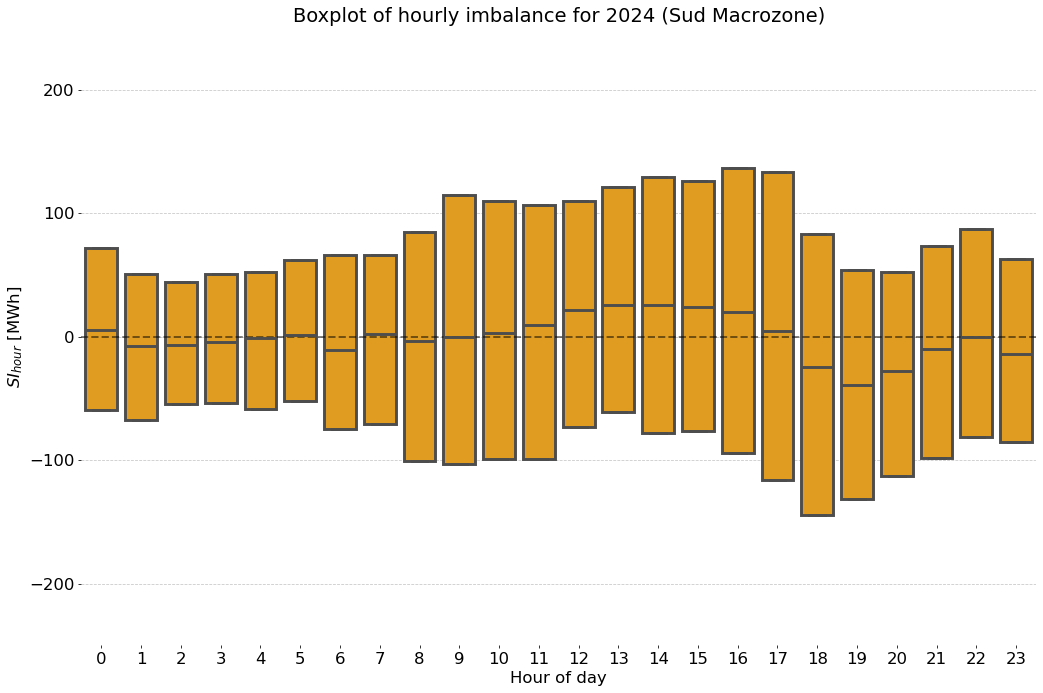

In [29]:
DPI = 70

# Ensure you are working on a copy of the DataFrame
qh_sud_2024 = qh_sud.loc["2024"].copy()

# Extract hour from the ORAINI index and create a new column 'hour' using .loc
qh_sud_2024.loc[:, 'hour'] = qh_sud_2024.index.hour

fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=qh_sud_2024, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='orange', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)
ax.set_title("Boxplot of hourly imbalance for 2024 (Sud Macrozone)", fontsize=20)

# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-250, 250])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


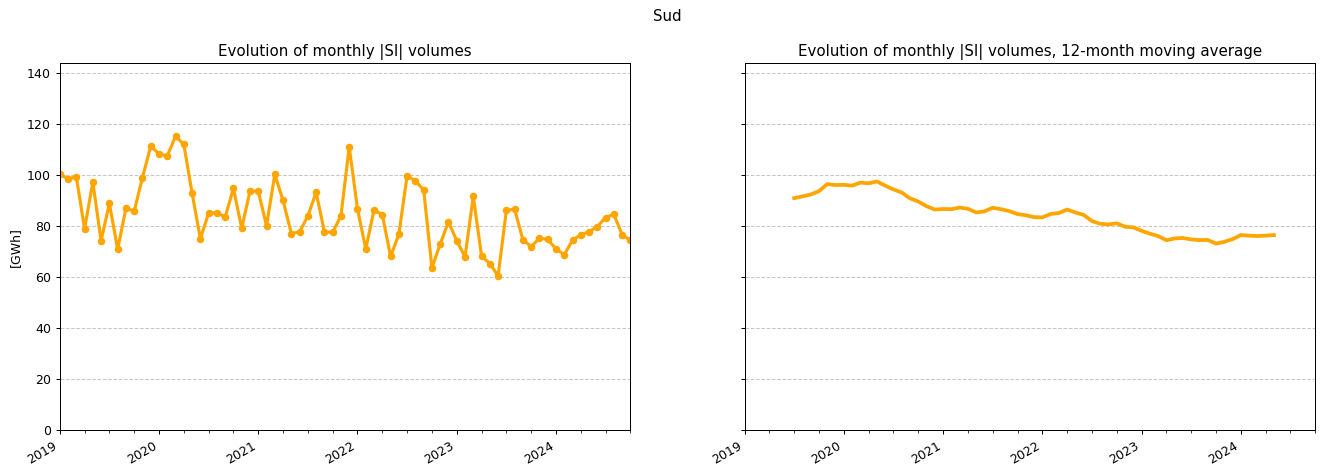

In [30]:
qh_sud_copy['year'] = qh_sud.index.year
qh_sud_copy['month'] = qh_sud.index.month

# Group by year and month, then apply the custom imbalance volume calculation
agg_month = (
    qh_sud_copy
    .groupby(by=["year", "month"])["SBIL_MWH"]
    .apply(calculate_imbalance_volume, how="sum")
)

# Adjust the date index range for the aggregated data
agg_month.index = pd.date_range(
    start=pd.Timestamp(f"{agg_month.index[0][0]}-{agg_month.index[0][1]}") - pd.DateOffset(months=0),
    end=pd.Timestamp(f"{agg_month.index[-1][0]}-{agg_month.index[-1][1]}") + pd.DateOffset(months=0),
    freq="1MS"
)

rolling_window = 12

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=90, sharex=True, sharey=True)
plt.title("Sud")
# Plot original monthly imbalance volume on the first subplot
agg_month.plot(ax=ax[0],
               ylabel="[GWh]",
               c="orange",
               linewidth=2.5,  # Increased linewidth for better visibility
               title=f"Evolution of monthly |SI| volumes")
agg_month.plot(ax=ax[0],
               style=".",
               color="orange",
               markersize=10)

# Plot rolling mean with the specified rolling window on the second subplot
agg_month.rolling(rolling_window, center=True).mean().plot(ax=ax[1],
                                                           ylabel="[GWh]",
                                                           c="orange",
                                                           linewidth=3,  # Increased line thickness for rolling average
                                                           title=f"Evolution of monthly |SI| volumes, {rolling_window}-month moving average")

# Set the y-axis limits dynamically based on the maximum value
plt.ylim(0, 1.25 * agg_month.max())



# Enable horizontal grid lines
ax[0].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to first plot
ax[1].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to second plot

# Automatically adjust x-axis label formatting
fig.autofmt_xdate()
fig.suptitle('Sud')
# Display the plot
plt.show()


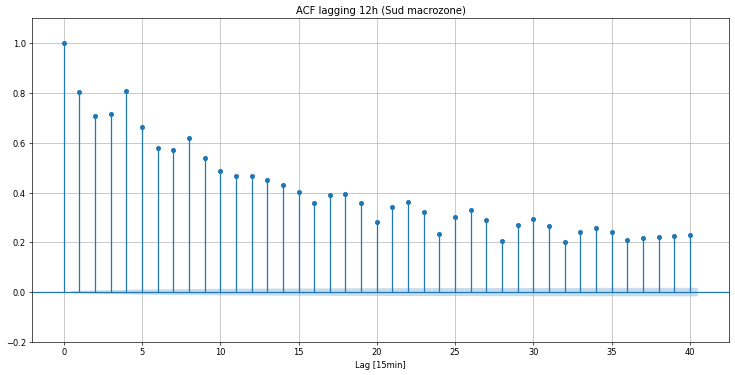

In [31]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_sud["SBIL_MWH"], alpha=.05, lags=4*10,
                         ax=ax, title="ACF lagging 12h (Sud macrozone)")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

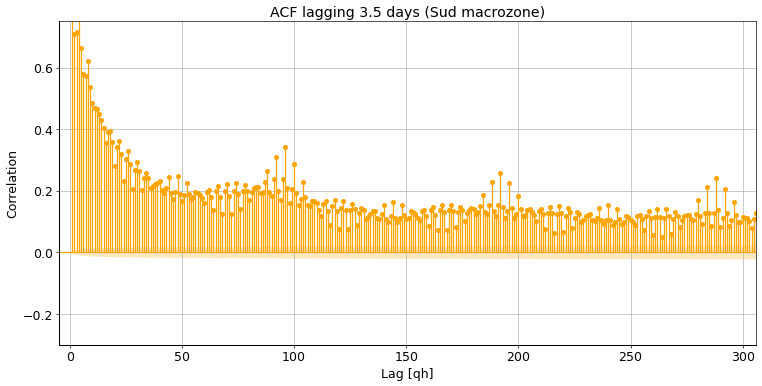

In [32]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_sud["SBIL_MWH"], alpha=.05, lags=4*24*3.5,
                         zero=False,
                         ax=ax,
                         color="orange", vlines_kwargs={"colors": "orange"})

ax.set_title("ACF lagging 3.5 days (Sud macrozone)", fontsize=17)
plt.ylim(-0.3, 0.75)
plt.xlim(-5, 4*24*3.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("orange")
plt.grid()
plt.show()

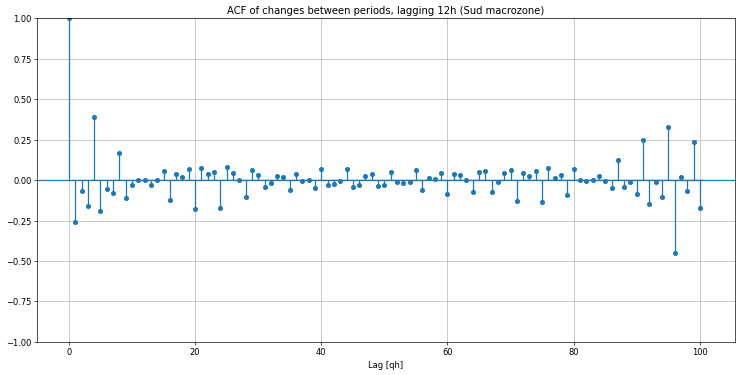

In [33]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(qh_sud["SBIL_MWH"].diff().diff(4*24).dropna(), alpha=.05, lags=100,
                         ax=ax, title="ACF of changes between periods, lagging 12h (Sud macrozone)")
# plt.ylim(-0.3, 1.1)
plt.xlabel('Lag [qh]')
plt.grid()
plt.show()

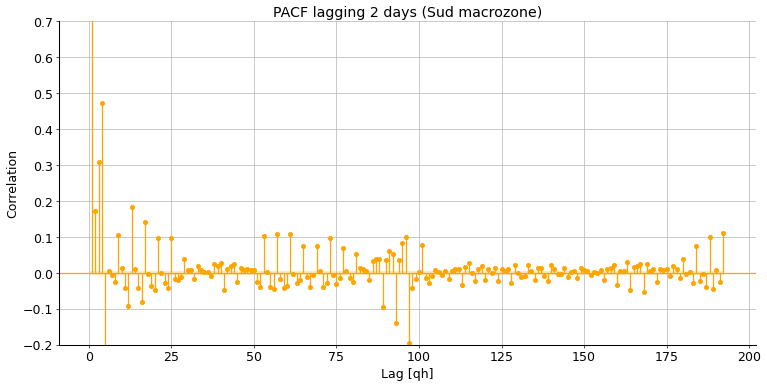

In [34]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_pacf(qh_sud["SBIL_MWH"], alpha=.05, lags=4*24*2, 
                         zero=False,
                         ax=ax,
                         color="orange", vlines_kwargs={"colors": "orange"})
plt.ylim(-0.2, 0.7)
# plt.xlim(-5, 4*24*2.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.set_title("PACF lagging 2 days (Sud macrozone)", fontsize=17)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("orange")
plt.grid()
plt.show()

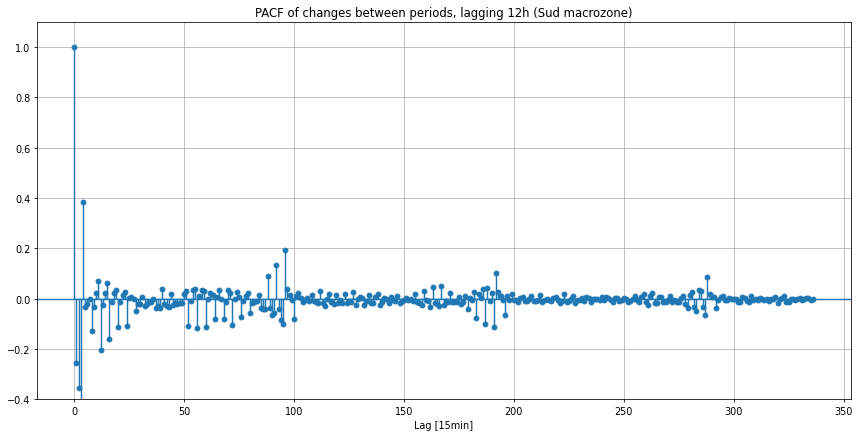

In [35]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_pacf(qh_sud["SBIL_MWH"].diff().dropna(), alpha=.05, lags=4*24*3.5, method="ywm", 
                          ax=ax, title="PACF of changes between periods, lagging 12h (Sud macrozone)")
plt.ylim([-0.4,1.1])
plt.xlabel('Lag [15min]')
plt.grid()
plt.show()

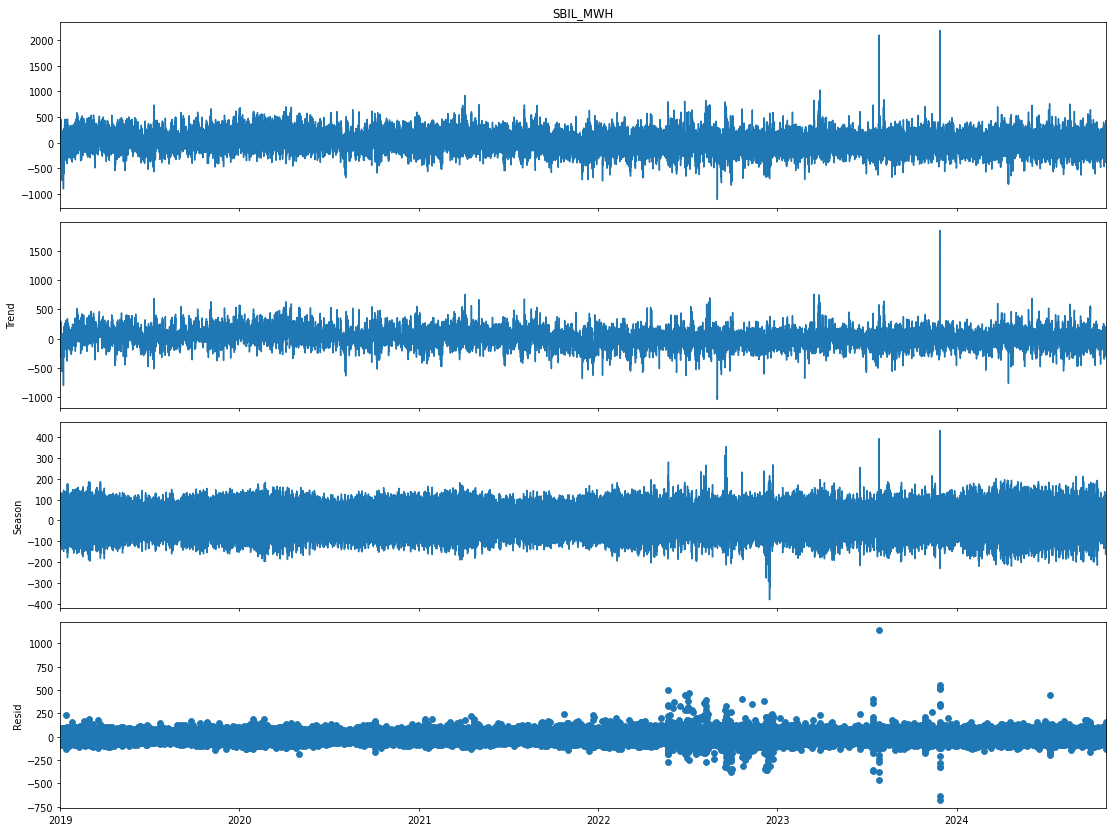

In [36]:
try_STL = True

if try_STL:
    decomp = STL(endog=qh_sud["SBIL_MWH"], period = 4).fit()   # , period=4, trend=int(4*24*7*4.35), seasonal=int(4*24*7*4.35), robust=True

    plt.rc('figure', figsize=(16, 12), dpi=DPI)
    decomp.plot()
    plt.show()
    plt.rcdefaults()